In [ ]:
# !pip install bayesian-optimization
# !pip install shap lime

In [ ]:
#@title Importing Libraries

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import r2_score, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import seaborn as sns
import shap
shap.initjs()
import lime, lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
#@title Preprocessing Database

irrelevant_columns = [
    "ID", "id", "Index", "index", "Serial Number", "serial_number",
    "Address", "address", "Href", "href", "Timestamp", "timestamp",
    "Creation Date", "creation_date", "Last Updated Date", "last_updated_date",
    "Version", "version", "Checksum", "checksum", "Year", "year"
    "Row ID", "row_id", "Record ID", "record_id", "Customer ID", "customer_id",
    "Client ID", "client_id", "Account ID", "account_id", "Transaction ID", "transaction_id",
    "Email", "email", "Phone Number", "phone_number", "Website", "website",
    "Fax", "fax", "IP Address", "ip_address", "MAC Address", "mac_address",
    "Social Security Number", "social_security_number", "Driver's License", "drivers_license",
    "ID_", "id_", "Index_", "index_", "Serial_Number", "serial_number_",
    "Address_", "address_", "Href_", "href_", "Timestamp_", "timestamp_",
    "Creation_Date", "creation_date_", "Last_Updated_Date", "last_updated_date_",
    "Version_", "version_", "Checksum_", "checksum_",
    "Row_ID", "row_id_", "Record_ID", "record_id_", "Customer_ID", "customer_id_",
    "Client_ID", "client_id_", "Account_ID", "account_id_", "Transaction_ID", "transaction_id_",
    "Email_", "email_", "Phone_Number", "phone_number_", "Website_", "website_",
    "Fax_", "fax_", "IP_Address", "ip_address_", "MAC_Address", "mac_address_",
    "Social_Security_Number", "social_security_number_", "Driver's_License", "drivers_license_"
]

ordinal_data = {
    'low':1,
    'medium':2,
    'moderate':2,
    'high':3,
    # Education Level
    'high school diploma': 1,
    'associate\'s degree': 2,
    'bachelor\'s degree': 3,
    'master\'s degree': 4,
    'doctorate degree': 5,
    # Income Level
    'low income': 1,
    'middle income': 2,
    'high income': 3,
    # Customer Satisfaction
    'very dissatisfied': 1,
    'dissatisfied': 2,
    'neutral': 3,
    'satisfied': 4,
    'very satisfied': 5,
    # Likert Scale
    'strongly disagree': 1,
    'disagree': 2,
    'neither agree nor disagree': 3,
    'agree': 4,
    'strongly agree': 5,
    # Job Seniority
    'entry-level': 1,
    'mid-level': 2,
    'senior-level': 3,
    'executive-level': 4,
    # Severity of Illness/Condition
    'mild': 1,
    'moderate': 2,
    'severe': 3,
    # Temperature
    'cold': 1,
    'warm': 2,
    'hot': 3,
    'very hot': 4,
    # Customer Rating
    '1 star': 1,
    '2 stars': 2,
    '3 stars': 3,
    '4 stars': 4,
    '5 stars': 5,
    # Likelihood of Purchase
    'very unlikely': 1,
    'unlikely': 2,
    'likely': 4,
    'very likely': 5,
    # Degree of Agreement
    'strongly disagree': 1,
    'disagree': 2,
    'neutral': 3,
    'agree': 4,
    'strongly agree': 5,
    # Pain Scale
    'no pain': 1,
    'mild pain': 2,
    'moderate pain': 3,
    'severe pain': 4,
    'extreme pain': 5,
    # Likelihood of Recommendation
    'very unlikely to recommend': 1,
    'unlikely to recommend': 2,
    'likely to recommend': 4,
    'very likely to recommend': 5,
    # Quality Ratings
    'poor quality': 1,
    'fair quality': 2,
    'good quality': 3,
    'very good quality': 4,
    'excellent quality': 5,
    # Customer Service Experience
    'very poor': 1,
    'poor': 2,
    'average': 3,
    'good': 4,
    'excellent': 5,
    # Ease of Use
    'very difficult': 1,
    'difficult': 2,
    'easy': 4,
    'very easy': 5,
    # Likelihood of Churn
    'very unlikely to churn': 1,
    'unlikely to churn': 2,
    'likely to churn': 4,
    'very likely to churn': 5,
    # Satisfaction with Product/Service
    'not satisfied': 1,
    'slightly satisfied': 2,
    'moderately satisfied': 3,
    'extremely satisfied': 5,
    # Risk Levels
    'low risk': 1,
    'moderate risk': 2,
    'high risk': 3,
    # Performance Ratings
    'below expectations': 1,
    'meeting expectations': 2,
    'exceeding expectations': 3 }

In [ ]:
#@title Data Preprocessing

def remove_irrelevant_columns(data, irrelevant_columns):
  columns_to_delete = [col for col in data.columns if col in irrelevant_columns]

  if len(columns_to_delete)>0:
    data.drop(columns=columns_to_delete, inplace=True)

  return data


def remove_duplicate_values(data):
  if data.duplicated().any():
    data.drop_duplicates(inplace=True)

  return data


def remove_constant_values(data):
  constant_columns = [col for col in data.columns if data[col].nunique() == 1]

  if len(constant_columns) > 0:
    data.drop(columns=constant_columns, inplace=True)

  return data


def remove_string_numerical(data):
  string_num_cols = [col for col in data.columns if data[col].dtype == 'object' and data[col].str.isnumeric().all()]

  if len(string_num_cols) > 0:
    data[string_num_cols] = data[string_num_cols].apply(pd.to_numeric)

  return data


def remove_object_numerical(data):
  import re
  object_cols = data.select_dtypes(include=['object']).columns

  if len(object_cols) > 0:
    for col in object_cols:
      numerical_values = data[col].apply(lambda x: re.findall(r'\d+\.\d+|\d+', str(x)))
      numeric_col = col + '_numeric'
      data[numeric_col] = numerical_values.apply(lambda x: float(x[0]) if x else None)

  return data


def missing_values(data, threshold=0.3, k_neighbors=5):
  numerical_cols = data.select_dtypes(include=['number']).columns
  categorical_cols = data.select_dtypes(include=['object']).columns

  if data.isnull().any().any():
      missing_percentage = data.isnull().mean()

      if (missing_percentage < threshold).any():
        imputer = KNNImputer(n_neighbors=k_neighbors)
        strategy = 'knn'
      else:
        imputer = SimpleImputer(strategy='mean')
        strategy = 'mean'
      if strategy == 'knn':
        imputer = KNNImputer(n_neighbors=k_neighbors)
      else:
        imputer = SimpleImputer(strategy=strategy)
      data[numerical_cols] = imputer.fit_transform(data[numerical_cols])
      mode_imputer = SimpleImputer(strategy='most_frequent')
      data[categorical_cols] = mode_imputer.fit_transform(data[categorical_cols])

  return data


# def convert_datetime(data):
#     object_cols = data.select_dtypes(include=['object']).columns

#     if len(object_cols) > 0:
#         for col in object_cols:
#             try:
#                 data[col] = pd.to_datetime(data[col])
#                 data[col + '_numeric'] = data[col].astype('int64') // 10**9
#                 data.drop(columns=[col], inplace=True)
#             except (ValueError, TypeError):
#                 pass

#     return data


def encode_objects(data):
  categorical_columns = data.select_dtypes(include=['object']).columns

  if len(categorical_columns) > 0:
    for col in categorical_columns:
      unique_values_count = data[col].nunique()

      if unique_values_count == 2:
        encoder = LabelEncoder()
        data[col] = encoder.fit_transform(data[col])

      elif unique_values_count <= 7:     #RE
          if all(value in ordinal_data for value in data[col].str.lower()):
            data[col] = data[col].str.lower().map(ordinal_data)
          elif any(word in data[col].str.lower() for word in ['low', 'medium', 'moderate', 'high']):
            data[col] = data[col].apply(lambda x: ordinal_data[x.lower()] if x.lower() in ordinal_data else x)
          else:
            encoder = OneHotEncoder(sparse_output=False, drop='first')
            encoded_values = encoder.fit_transform(data[[col]])
            col_names = [f"{col}_{value}" for value in encoder.categories_[0][1:]]
            df = pd.DataFrame(encoded_values, columns=col_names)
            data = pd.concat([data, df], axis=1)
            data.drop(columns=[col], inplace=True)

      #else : LabelEncoder()

  return data


def adjust_values(data):
  scaler = StandardScaler()
  scaler.fit_transform(data)
  #scipy
  return data


#master function
def preprocess_data(data, threshold=0.5, k_neighbors=5):

    data = remove_irrelevant_columns(data, irrelevant_columns)
    data = remove_duplicate_values(data)
    data = remove_constant_values(data)
    data = remove_string_numerical(data)
    data = remove_object_numerical(data)
    data = missing_values(data, threshold, k_neighbors)
    # data = convert_datetime(data)
    data = encode_objects(data) #
    # data = adjust_values(data)

    return data

In [ ]:
#@title Feature selection

from sklearn.feature_selection import SelectKBest, f_classif, f_regression

def feature_selection(X, y, problem_type, k=11):
    if problem_type == 'Classification':
        selector = SelectKBest(score_func=f_classif, k=k)
    elif problem_type == 'Regression':
        selector = SelectKBest(score_func=f_regression, k=k)
    else:
        print("Invalid problem type. Use 'Classification' or 'Regression' !!")
        return None

    X_new = selector.fit_transform(X, y)
    selected_features = selector.get_support(indices=True)
    X_selected = pd.DataFrame(X_new, columns=[f'feature_{i}' for i in selected_features])

    return X_selected

In [ ]:
#@title Model Selection

def algorithm_type(x_var, y_var):
    from sklearn.utils.multiclass import type_of_target
    dtype = y_var.dtype
    target_type = type_of_target(y_var)

    if dtype == 'object' or target_type == 'binary':
      problem_type = 'Classification'
      print('Categorical(binary) target variable detected !')

    elif target_type == 'continuous':
      problem_type = 'Regression'
      print('Continuous target variable detected !')

    elif dtype in ['int64','float64'] or target_type in ['multiclass']:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.23, random_state=42)
        rf_classifier = RandomForestClassifier()
        rf_regressor = RandomForestRegressor()
        rf_classifier.fit(X_train, y_train)
        rf_regressor.fit(X_train, y_train)
        classifier_score = rf_classifier.score(X_test, y_test)
        regressor_score = rf_regressor.score(X_test, y_test)
        if classifier_score > regressor_score:
          print('Categorical target variable detected !!')
          problem_type = 'Classification'
        else:
          print('Continuous target variable detected !!')
          problem_type = 'Regression'
        # print(f'CS:{classifier_score} , RS:{regressor_score}')

    else:
        problem_type = input('''Specify problem type manually -
        (r for Regression / c for Classification) : ''')

    return problem_type


def model_analysis(ptype):
    if ptype.lower() in ['Regression','regression', 'r']:
        models = [
            ('DecisionTreeRegressor', DecisionTreeRegressor()),
            ('RandomForestRegressor', RandomForestRegressor()),
            ('GradientBoostingRegressor', GradientBoostingRegressor())
        ]
    elif ptype.lower() in ['Classification','classification', 'c']:
        models = [
            ('DecisionTreeClassifier', DecisionTreeClassifier()),
            ('RandomForestClassifier', RandomForestClassifier()),
            ('GradientBoostingClassifier', GradientBoostingClassifier())
        ]
    else:
        raise ValueError('Invalid problem type specified.')

    return models


def model_selection(models, X, y, problem_type, cv=3):
    if len(X) > 3333:
        random_indices = np.random.choice(len(X), 3333, replace=False)
        X_temp = X.iloc[random_indices]
        y_temp = y.iloc[random_indices]
    else:
        X_temp = X
        y_temp = y

    best_model = None
    best_score = float('-inf') if problem_type == 'Regression' else 0

    for name, model in models:
        scoring = 'r2' if problem_type == 'Regression' else 'accuracy'
        scores = cross_val_score(model, X_temp, y_temp, scoring=scoring, cv=cv)
        mean_score = scores.mean()
        if problem_type == 'Regression' and mean_score > best_score:
            best_score = mean_score
            best_model = model
        elif problem_type == 'Classification' and mean_score > best_score:
            best_score = mean_score
            best_model = model
    return best_model

In [ ]:
#@title Optimizer Functions

# Decision Tree Regressor Optimization
def optimize_dtr(X_train, X_test, y_train, y_test):
    def dtr_optimizer(max_depth, min_samples_split, min_samples_leaf):
        dtr = DecisionTreeRegressor(max_depth=int(max_depth), min_samples_split=int(min_samples_split),
                                     min_samples_leaf=int(min_samples_leaf))
        dtr.fit(X_train, y_train)
        y_pred = dtr.predict(X_test)
        return r2_score(y_test, y_pred), {'max_depth': int(max_depth),
                                          'min_samples_split': int(min_samples_split),
                                          'min_samples_leaf': int(min_samples_leaf)}

    dtr_bounds = {'max_depth': (1, 50), 'min_samples_split': (2, 20),
                  'min_samples_leaf': (1, 20)}

    bayes_dtr = BayesianOptimization(f=dtr_optimizer, pbounds=dtr_bounds, random_state=42)
    bayes_dtr.maximize(init_points=10, n_iter=10)
    best_params = bayes_dtr.max['params']

    dtr_final = DecisionTreeClassifier(max_depth=int(round(best_params['max_depth'])),
                                       min_samples_split=int(best_params['min_samples_split']),
                                       min_samples_leaf=int(best_params['min_samples_leaf']))
    dtr_final.fit(X_train, y_train)

    y_pred = dtr_final.predict(X_test)
    performance = r2_score(y_test, y_pred)

    return dtr_final, performance


# Random Forest Regressor Optimization
def optimize_rfr(X_train, X_test, y_train, y_test):
    def rfr_optimizer(n_estimators, max_depth, min_samples_split, min_samples_leaf):
        rfr = RandomForestRegressor(n_estimators=int(round(n_estimators)), max_depth=int(round(max_depth)),
                                     min_samples_split=int(min_samples_split), min_samples_leaf=int(min_samples_leaf))
        rfr.fit(X_train, y_train)
        y_pred = rfr.predict(X_test)
        return r2_score(y_test, y_pred)

    rfr_bounds = {'n_estimators': (10, 100), 'max_depth': (1, 50), 'min_samples_split': (2, 20),
                  'min_samples_leaf': (1, 20)}

    bayes_rfr = BayesianOptimization(f=rfr_optimizer, pbounds=rfr_bounds, random_state=42)
    bayes_rfr.maximize(init_points=10, n_iter=10)
    best_params = bayes_rfr.max['params']

    rfr_final = RandomForestRegressor(n_estimators=int(round(best_params['n_estimators'])),
                                      max_depth=int(round(best_params['max_depth'])),
                                      min_samples_split=int(best_params['min_samples_split']),
                                      min_samples_leaf=int(best_params['min_samples_leaf']))
    rfr_final.fit(X_train, y_train)

    y_pred = rfr_final.predict(X_test)
    performance = r2_score(y_test, y_pred)

    return rfr_final, performance


# Gradient Boosting Regressor Optimization
def optimize_gbr(X_train, X_test, y_train, y_test):
    def gbr_optimizer(n_estimators, learning_rate, max_depth, min_samples_split, min_samples_leaf, subsample):
        gbr = GradientBoostingRegressor(n_estimators=int(round(n_estimators)), learning_rate=learning_rate,
                                         max_depth=int(round(max_depth)), min_samples_split=int(min_samples_split),
                                         min_samples_leaf=int(min_samples_leaf), subsample=subsample)
        gbr.fit(X_train, y_train)
        y_pred = gbr.predict(X_test)
        return r2_score(y_test, y_pred)

    gbr_bounds = {'n_estimators': (10, 100), 'learning_rate': (0.001, 1.0), 'max_depth': (1, 50),
                  'min_samples_split': (2, 20), 'min_samples_leaf': (1, 20), 'subsample': (0.1, 1.0)}

    bayes_gbr = BayesianOptimization(f=gbr_optimizer, pbounds=gbr_bounds, random_state=42)
    bayes_gbr.maximize(init_points=10, n_iter=10)
    best_params = bayes_gbr.max['params']

    gbr_final = GradientBoostingRegressor(n_estimators=int(round(best_params['n_estimators'])),
                                           learning_rate=best_params['learning_rate'],
                                           max_depth=int(round(best_params['max_depth'])),
                                           min_samples_split=int(best_params['min_samples_split']),
                                           min_samples_leaf=int(best_params['min_samples_leaf']),
                                           subsample=best_params['subsample'])
    gbr_final.fit(X_train, y_train)

    y_pred = gbr_final.predict(X_test)
    performance = r2_score(y_test, y_pred)

    return gbr_final, performance


# Decision Tree Classifier Optimization
def optimize_dtc(X_train, X_test, y_train, y_test):
    def dtc_optimizer(max_depth, min_samples_split, min_samples_leaf):
        dtc = DecisionTreeClassifier(max_depth=int(round(max_depth)), min_samples_split=int(min_samples_split),
                                      min_samples_leaf=int(min_samples_leaf))
        dtc.fit(X_train, y_train)
        y_pred = dtc.predict(X_test)
        return accuracy_score(y_test, y_pred)

    dtc_bounds = {'max_depth': (1, 50), 'min_samples_split': (2, 20),
                  'min_samples_leaf': (1, 20)}

    bayes_dtc = BayesianOptimization(f=dtc_optimizer, pbounds=dtc_bounds, random_state=42)
    bayes_dtc.maximize(init_points=10, n_iter=10)
    best_params = bayes_dtc.max['params']

    dtc_final = DecisionTreeClassifier(max_depth=int(round(best_params['max_depth'])),
                                       min_samples_split=int(best_params['min_samples_split']),
                                       min_samples_leaf=int(best_params['min_samples_leaf']))
    dtc_final.fit(X_train, y_train)

    y_pred = dtc_final.predict(X_test)
    performance = accuracy_score(y_test, y_pred)

    return dtc_final, performance


# Random Forest Classifier Optimization
def optimize_rfc(X_train, X_test, y_train, y_test):
    def rfc_optimizer(n_estimators, max_depth, min_samples_split, min_samples_leaf):
        rfc = RandomForestClassifier(n_estimators=int(round(n_estimators)), max_depth=int(round(max_depth)),
                                      min_samples_split=int(min_samples_split), min_samples_leaf=int(min_samples_leaf))
        rfc.fit(X_train, y_train)
        y_pred = rfc.predict(X_test)
        return accuracy_score(y_test, y_pred)

    rfc_bounds = {'n_estimators': (10, 100), 'max_depth': (1, 50), 'min_samples_split': (2, 20),
                  'min_samples_leaf': (1, 20)}

    bayes_rfc = BayesianOptimization(f=rfc_optimizer, pbounds=rfc_bounds, random_state=42)
    bayes_rfc.maximize(init_points=10, n_iter=10)
    best_params = bayes_rfc.max['params']

    rfc_final = RandomForestClassifier(n_estimators=int(round(best_params['n_estimators'])),
                                       max_depth=int(round(best_params['max_depth'])),
                                       min_samples_split=int(best_params['min_samples_split']),
                                       min_samples_leaf=int(best_params['min_samples_leaf']))
    rfc_final.fit(X_train, y_train)

    y_pred = rfc_final.predict(X_test)
    performance = accuracy_score(y_test, y_pred)

    return rfc_final, performance


# Gradient Boosting Classifier Optimization
def optimize_gbc(X_train, X_test, y_train, y_test):
    def gbc_optimizer(n_estimators, learning_rate, max_depth, min_samples_split, min_samples_leaf, subsample):
        gbc = GradientBoostingClassifier(n_estimators=int(n_estimators), learning_rate=learning_rate,
                                         max_depth=int(max_depth), min_samples_split=int(min_samples_split),
                                         min_samples_leaf=int(min_samples_leaf), subsample=subsample)
        gbc.fit(X_train, y_train)
        y_pred = gbc.predict(X_test)
        return accuracy_score(y_test, y_pred), {'n_estimators': int(n_estimators),
                                                'learning_rate': learning_rate,
                                                'max_depth': int(max_depth),
                                                'min_samples_split': int(min_samples_split),
                                                'min_samples_leaf': int(min_samples_leaf),
                                                'subsample': subsample}

    gbc_bounds = {'n_estimators': (10, 100), 'learning_rate': (0.001, 1.0), 'max_depth': (1, 50),
                  'min_samples_split': (2, 20), 'min_samples_leaf': (1, 20), 'subsample': (0.1, 1.0)}

    bayes_gbc = BayesianOptimization(f=gbc_optimizer, pbounds=gbc_bounds, random_state=42)
    bayes_gbc.maximize(init_points=10, n_iter=10)
    best_params = bayes_gbc.max['params']
    accuracy = bayes_gbc.max['target']

    gbc_final = GradientBoostingClassifier(n_estimators=int(round(best_params['n_estimators'])),
                                           learning_rate=best_params['learning_rate'],
                                           max_depth=int(round(best_params['max_depth'])),
                                           min_samples_split=int(best_params['min_samples_split']),
                                           min_samples_leaf=int(best_params['min_samples_leaf']),
                                           subsample=best_params['subsample'])
    gbc_final.fit(X_train, y_train)

    y_pred = gbc_final.predict(X_test)
    performance = accuracy_score(y_test, y_pred)

    return gbc_final, performance

In [ ]:
#@title Model Optimization and Training
def optimize_model(algorithm, model, X_train, X_test, y_train, y_test):
    optimized_model = None
    score = 0
    if algorithm.lower() == 'regression':
      if isinstance(model, DecisionTreeRegressor):
          optimized_model, score = optimize_dtr(X_train, X_test, y_train, y_test)
      elif isinstance(model, RandomForestRegressor):
          optimized_model, score = optimize_rfr(X_train, X_test, y_train, y_test)
      elif isinstance(model, GradientBoostingRegressor):
          optimized_model, score = optimize_gbr(X_train, X_test, y_train, y_test)

    elif algorithm.lower() == 'classification':
      if isinstance(model, DecisionTreeClassifier):
          optimized_model, score = optimize_dtc(X_train, X_test, y_train, y_test)
      elif isinstance(model, RandomForestClassifier):
          optimized_model, score = optimize_rfc(X_train, X_test, y_train, y_test)
      elif isinstance(model, GradientBoostingClassifier):
          optimized_model, score = optimize_gbc(X_train, X_test, y_train, y_test)

    else:
        print('No model selected !!')
        optimized_model = None

    return optimized_model, score

In [ ]:
#@title Model Evaluation

def model_predict(model, X_train, X_test):
  train_predictions = model.predict(X_train)
  test_predictions = model.predict(X_test)

  return train_predictions, test_predictions


def evaluate_model(y_train, y_train_pred, y_test, y_test_pred, problem_type):

  if problem_type == "Regression":
      r2_train = r2_score(y_train, y_train_pred)
      mae_train = mean_absolute_error(y_train, y_train_pred)
      mse_train = mean_squared_error(y_train, y_train_pred)
      rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
      r2_test = r2_score(y_test, y_test_pred)
      mae_test = mean_absolute_error(y_test, y_test_pred)
      mse_test = mean_squared_error(y_test, y_test_pred)
      rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

      print("Training Metrics:")
      print(f"R-squared:               {r2_train:.4f}")
      print(f"Mean Absolute Error:     {mae_train:.4f}")
      print(f"Mean Squared Error:      {mse_train:.4f}")
      print(f"Root Mean Squared Error: {rmse_train:.4f}")
      print()
      print("Testing Metrics:")
      print(f"R-squared:               {r2_test:.4f}")
      print(f"Mean Absolute Error:     {mae_test:.4f}")
      print(f"Mean Squared Error:      {mse_test:.4f}")
      print(f"Root Mean Squared Error: {rmse_test:.4f}")

  else:
      accuracy_train = accuracy_score(y_train, y_train_pred)
      f1_train = f1_score(y_train, y_train_pred)
      precision_train = precision_score(y_train, y_train_pred)
      recall_train = recall_score(y_train, y_train_pred)
      accuracy_test = accuracy_score(y_test, y_test_pred)
      f1_test = f1_score(y_test, y_test_pred)
      precision_test = precision_score(y_test, y_test_pred)
      recall_test = recall_score(y_test, y_test_pred)

      print("Training Metrics:")
      print(f"Accuracy:  {accuracy_train:.4f}")
      print(f"F1 Score:  {f1_train:.4f}")
      print(f"Precision: {precision_train:.4f}")
      print(f"Recall:    {recall_train:.4f}")
      print()
      print("Testing Metrics:")
      print(f"Accuracy:  {accuracy_test:.4f}")
      print(f"F1 Score:  {f1_test:.4f}")
      print(f"Precision: {precision_test:.4f}")
      print(f"Recall:    {recall_test:.4f}")

In [ ]:
#@title SHAP and LIME Explainers

def SHAP_local_expl(shap_val, i):
  shap.plots.waterfall(shap_val[i])
  print()
  feature_names = exp_data.columns
  feature_values = exp_data.iloc[i]
  shap_contributions = shap_val[i].values
  df = pd.DataFrame({
      'Feature': feature_names,
      'Value': feature_values,
      'SHAP Contribution': shap_contributions
  })
  print(df.to_string(index=False))

def LIME_local_expl(explainer_object,model,i):
  explanation = explainer_object.explain_instance(X_test.iloc[i], model.predict)
  explanation.as_pyplot_figure()
  plt.title(f'Local Explanation : Instance: {i}')
  plt.tight_layout()
  plt.show()
  print()
  df = pd.DataFrame(explanation.as_list(), columns=['Feature', 'Weight'])
  print(df)

def SHAP_plots(shap_vals):
  print("Bar plot for SHAP values :")
  shap.plots.bar(shap_vals)
  print("\nBeeswarm plot for SHAP values :")
  shap.plots.beeswarm(shap_vals)
  print("\nHeatmap for SHAP values :")
  shap.plots.heatmap(shap_vals, instance_order=shap_values.sum(1))

In [ ]:
org_dataset = pd.read_csv('powerplant_energy_data.csv')

dataset = org_dataset.copy()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ambient_temparature  9568 non-null   float64
 1   exhaust_vaccum       9568 non-null   float64
 2   ambient_pressure     9568 non-null   float64
 3   relative_humidity    9568 non-null   float64
 4   energy_output        9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [ ]:
data = preprocess_data(dataset)

print("Column Names with Indexes:")
for idx, col_name in enumerate(data.columns):
    print(f"Index {idx}: {col_name}")
target_col_idx = int(input("Enter the index of the target variable column: "))

X = data.drop(data.columns[target_col_idx], axis=1)
y = data.iloc[:, target_col_idx]

Column Names with Indexes:
Index 0: ambient_temparature
Index 1: exhaust_vaccum
Index 2: ambient_pressure
Index 3: relative_humidity
Index 4: energy_output
Enter the index of the target variable column: 4


In [ ]:
algorithm = algorithm_type(X, y)
print(f"{algorithm} Algorithm !")

if X.shape[1] > 11:
  X = feature_selection(X, y, algorithm)
  print('Feature selection Executed sucessfully !!')

Continuous target variable detected !
Regression Algorithm !


In [ ]:
X.info()
print()  ##
y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9527 entries, 0 to 9567
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ambient_temparature  9527 non-null   float64
 1   exhaust_vaccum       9527 non-null   float64
 2   ambient_pressure     9527 non-null   float64
 3   relative_humidity    9527 non-null   float64
dtypes: float64(4)
memory usage: 372.1 KB

<class 'pandas.core.series.Series'>
Index: 9527 entries, 0 to 9567
Series name: energy_output
Non-Null Count  Dtype  
--------------  -----  
9527 non-null   float64
dtypes: float64(1)
memory usage: 148.9 KB


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(f'{algorithm} Analysis : ')

models = model_analysis(algorithm)
print(models)

print()

best_model = model_selection(models, X, y, algorithm)
print(f'Model selected : {best_model} !!')

print()

print("Optimizing Model :")
final_model, performace = optimize_model(algorithm, best_model, X_train, X_test, y_train, y_test)
print(f"Model : {best_model}")
print(f"Performance : {performace}")

print()

print("Model Evaluation : ")
train_pred, test_pred = model_predict(final_model, X_train, X_test)
evaluate_model(y_train, train_pred, y_test, test_pred, algorithm)

Regression Analysis : 
[('DecisionTreeRegressor', DecisionTreeRegressor()), ('RandomForestRegressor', RandomForestRegressor()), ('GradientBoostingRegressor', GradientBoostingRegressor())]

Model selected : RandomForestRegressor() !!

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.9501    | 19.35     | 19.06     | 15.18     | 63.88     |
| 2         | 0.9533    | 8.645     | 3.964     | 3.046     | 87.96     |
| 3         | 0.9521    | 30.45     | 14.45     | 2.371     | 97.29     |
| 4         | 0.9566    | 41.79     | 5.034     | 5.273     | 26.51     |
| 5         | 0.9535    | 15.91     | 10.97     | 9.775     | 36.21     |
| 6         | 0.9588    | 30.98     | 3.65      | 7.259     | 42.97     |
| 7         | 0.9518    | 23.35     | 15.92     | 5.594     | 56.28     |
| 8         | 0.9565    | 30.03     | 1.883     | 12.94     | 25.35     |
| 9         | 0.9292    | 

In [ ]:
exp_data = X.head(1000) if len(X) > 1000 else X
mode = 'regression' if algorithm == 'Regression' else 'classification'

In [ ]:
shap_explainer = shap.Explainer(final_model)
shap_values = shap_explainer(exp_data)
print(f"SHAP values dimernsions : {shap_values.shape}")

feature_names = X_train.columns.tolist()
lime_explainer = LimeTabularExplainer(X_train.values, mode=mode, feature_names=feature_names)

SHAP values dimernsions : (1000, 4)


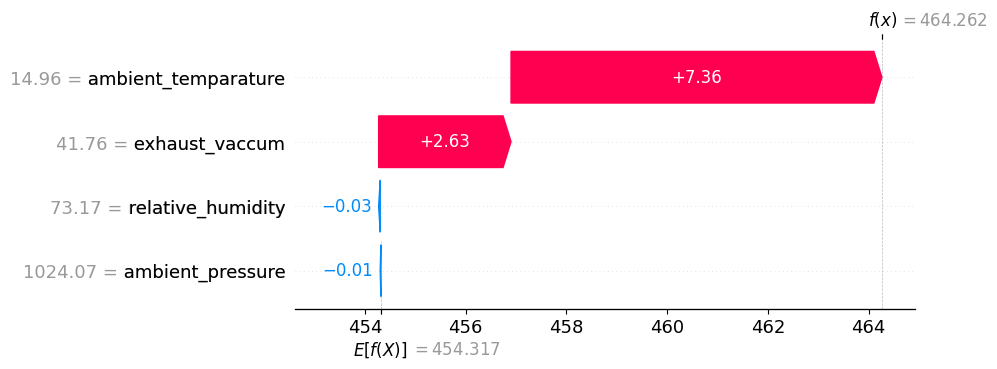


            Feature   Value  SHAP Contribution
ambient_temparature   14.96           7.361956
     exhaust_vaccum   41.76           2.628266
   ambient_pressure 1024.07          -0.012918
  relative_humidity   73.17          -0.031561


In [ ]:
SHAP_local_expl(shap_values, 0)

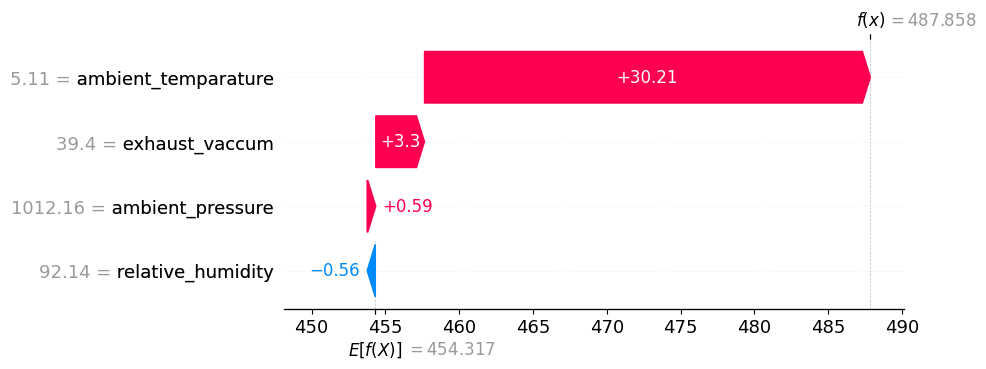


            Feature   Value  SHAP Contribution
ambient_temparature    5.11          30.210313
     exhaust_vaccum   39.40           3.301628
   ambient_pressure 1012.16           0.585039
  relative_humidity   92.14          -0.555381


In [ ]:
SHAP_local_expl(shap_values, 2)

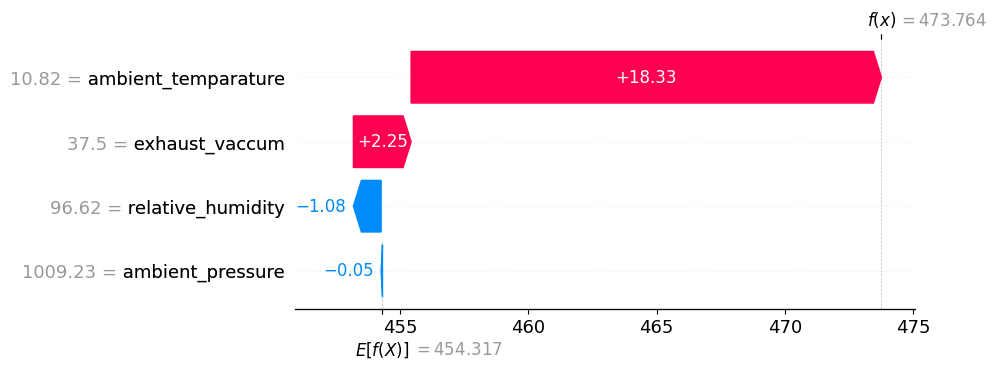


            Feature   Value  SHAP Contribution
ambient_temparature   10.82          18.331952
     exhaust_vaccum   37.50           2.249536
   ambient_pressure 1009.23          -0.053615
  relative_humidity   96.62          -1.079988


In [ ]:
SHAP_local_expl(shap_values, 4)

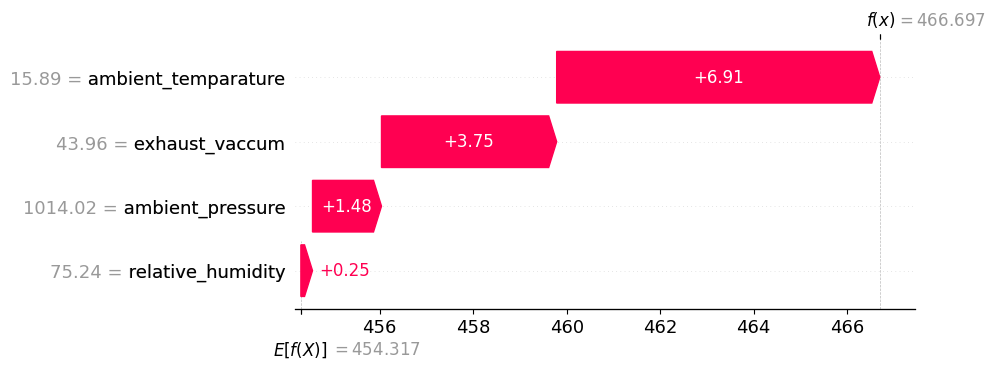


            Feature   Value  SHAP Contribution
ambient_temparature   15.89           6.909883
     exhaust_vaccum   43.96           3.746232
   ambient_pressure 1014.02           1.475150
  relative_humidity   75.24           0.248764


In [ ]:
SHAP_local_expl(shap_values, 6)

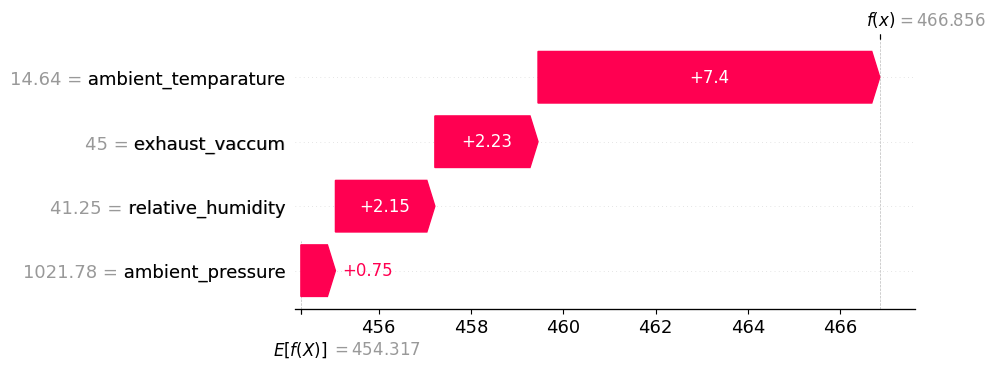


            Feature   Value  SHAP Contribution
ambient_temparature   14.64           7.402844
     exhaust_vaccum   45.00           2.234272
   ambient_pressure 1021.78           0.748099
  relative_humidity   41.25           2.153956


In [ ]:
SHAP_local_expl(shap_values, 8)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


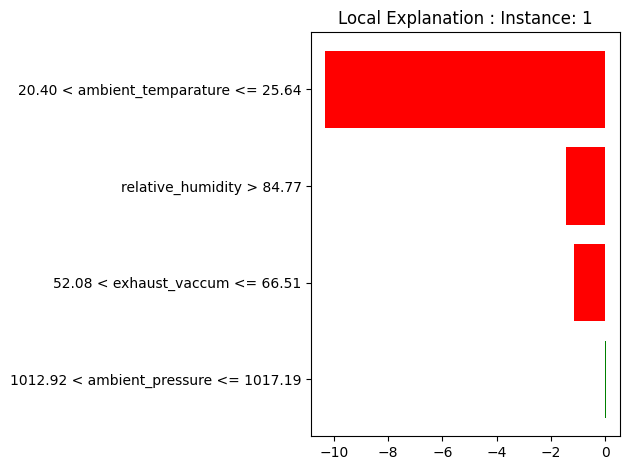


                                 Feature     Weight
0   20.40 < ambient_temparature <= 25.64 -10.320506
1              relative_humidity > 84.77  -1.435720
2        52.08 < exhaust_vaccum <= 66.51  -1.134880
3  1012.92 < ambient_pressure <= 1017.19   0.027126


In [ ]:
LIME_local_expl(lime_explainer,final_model,1)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


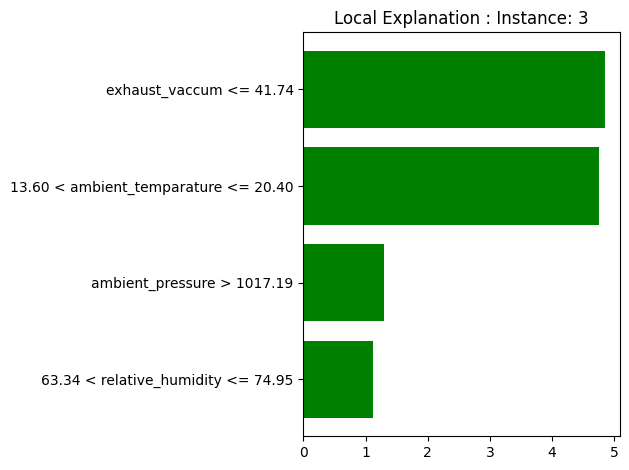


                                Feature    Weight
0               exhaust_vaccum <= 41.74  4.849211
1  13.60 < ambient_temparature <= 20.40  4.755351
2            ambient_pressure > 1017.19  1.292035
3    63.34 < relative_humidity <= 74.95  1.122428


In [ ]:
LIME_local_expl(lime_explainer,final_model,3)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


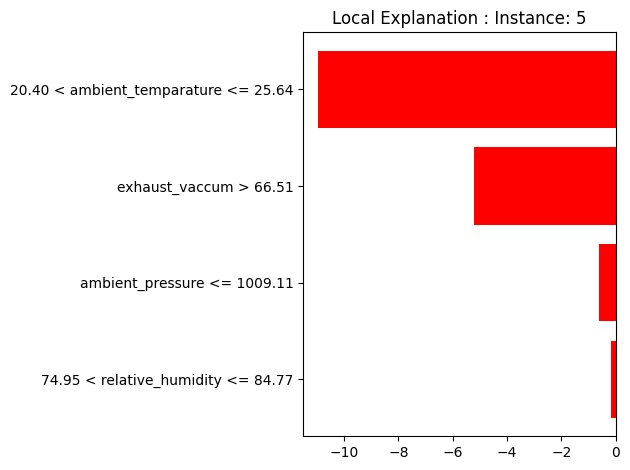


                                Feature     Weight
0  20.40 < ambient_temparature <= 25.64 -10.955846
1                exhaust_vaccum > 66.51  -5.209280
2           ambient_pressure <= 1009.11  -0.622284
3    74.95 < relative_humidity <= 84.77  -0.187886


In [ ]:
LIME_local_expl(lime_explainer,final_model,5)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


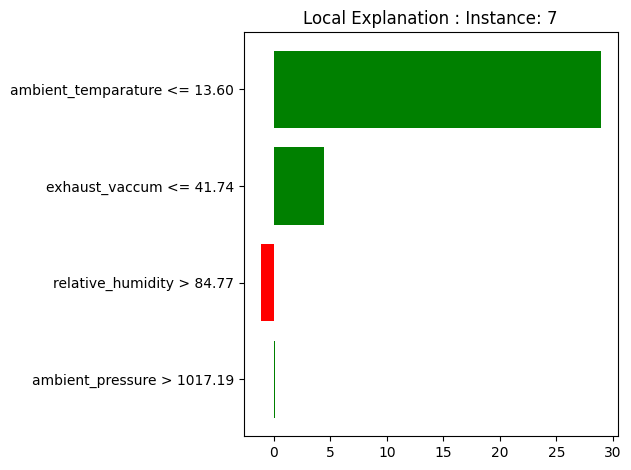


                        Feature     Weight
0  ambient_temparature <= 13.60  28.938136
1       exhaust_vaccum <= 41.74   4.398489
2     relative_humidity > 84.77  -1.172473
3    ambient_pressure > 1017.19   0.100610


In [ ]:
LIME_local_expl(lime_explainer,final_model,7)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


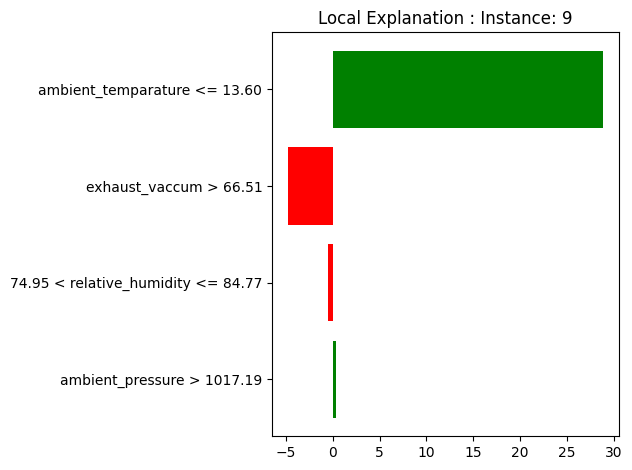


                              Feature     Weight
0        ambient_temparature <= 13.60  28.876871
1              exhaust_vaccum > 66.51  -4.820403
2  74.95 < relative_humidity <= 84.77  -0.526119
3          ambient_pressure > 1017.19   0.365374


In [ ]:
LIME_local_expl(lime_explainer,final_model,9)

Bar plot for SHAP values :


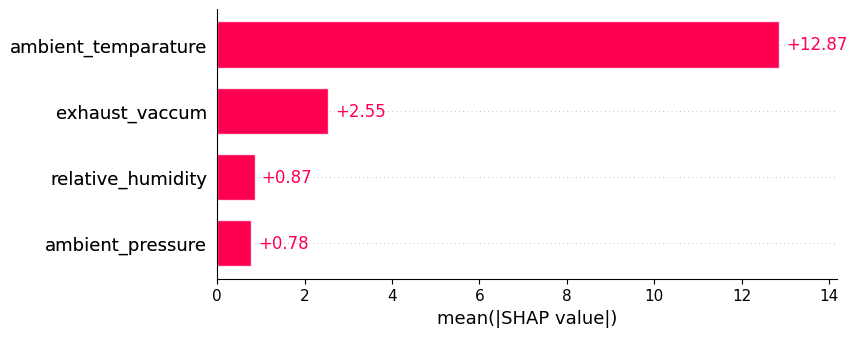


Beeswarm plot for SHAP values :


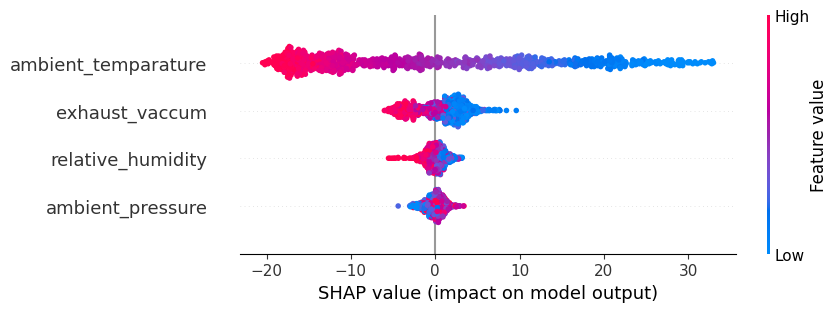


Heatmap for SHAP values :


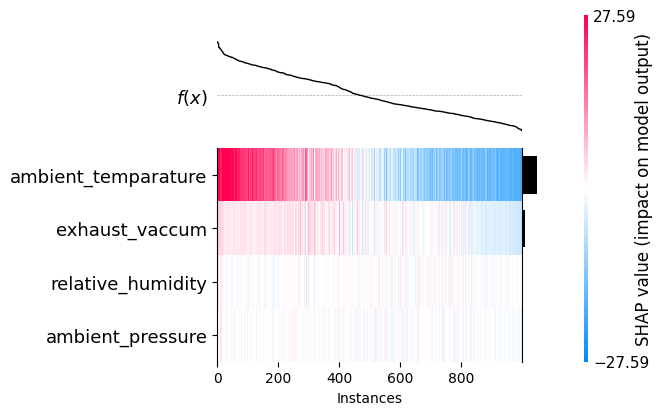

In [ ]:
SHAP_plots(shap_values)